In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np

2024-02-11 04:57:30.505116: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-11 04:57:30.505265: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-11 04:57:30.629976: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
## Downloading DeepWeeds Data  ## For Google Colab
# url = 'https://drive.google.com/uc?export=download&id=1xnK3B6K6KekDI55vwJ0vnc2IGoDga9cj'
# !gdown 1xnK3B6K6KekDI55vwJ0vnc2IGoDga9cj
# !unzip -qq images.zip -d images

In [3]:
# data_info = pd.read_csv('https://raw.githubusercontent.com/AlexOlsen/DeepWeeds/master/labels/labels.csv') ## for GoogleColab
data_info = pd.read_csv("/kaggle/input/deepweeds/labels.csv") ## For Kaggle
data_info

,Filename,Label,Species
0,20160928-140314-0.jpg,0,Chinee apple
1,20160928-140337-0.jpg,0,Chinee apple
2,20160928-140731-0.jpg,0,Chinee apple
3,20160928-140747-0.jpg,0,Chinee apple
4,20160928-141107-0.jpg,0,Chinee apple
...,...,...,...
17504,20180322-133822-1.jpg,8,Negative
17505,20180322-133832-1.jpg,8,Negative
17506,20180322-133840-1.jpg,8,Negative
17507,20180322-133850-1.jpg,8,Negative


In [4]:
data_info[['Species','Label']].value_counts()

Species         Label
Negative        8        9106
Chinee apple    0        1125
Siam weed       6        1074
Lantana         1        1064
Prickly acacia  4        1062
Parkinsonia     2        1031
Parthenium      3        1022
Snake weed      7        1016
Rubber vine     5        1009
Name: count, dtype: int64

In [7]:
# prompt: train test split using data_info
from sklearn.model_selection import train_test_split

trax, tex, tray, tey = train_test_split(data_info['Filename'],data_info['Label'], test_size=0.2, random_state=666)
train_data = pd.DataFrame({"Filename":trax,"Label":tray})

# trax, tex, tray, tey = train_test_split(tex,tey, test_size=0.5, random_state=99)
# valid_data = pd.DataFrame({"Filename":trax,"Label":tray})
test_data = pd.DataFrame({"Filename":tex,"Label":tey})

# print("Is There Duplicates: ", not valid_data[valid_data['Filename'].isin(test_data['Filename'])].empty)
train_data.shape, test_data.shape #, valid_data.shape

((14007, 2), (3502, 2))

In [8]:
train_data['Label'].value_counts(), test_data['Label'].value_counts()

(Label
 8    7291
 0     907
 6     855
 4     850
 1     848
 3     831
 2     826
 7     812
 5     787
 Name: count, dtype: int64,
 Label
 8    1815
 5     222
 6     219
 0     218
 1     216
 4     212
 2     205
 7     204
 3     191
 Name: count, dtype: int64)

## Creating Dateset ImageGenerator

In [9]:
import os
import shutil
from tqdm.auto import tqdm

# base_dir = '/content/images' ## For GoogleColab
# input_dir = base_dir ## For GoogleColab

input_dir = "/kaggle/input/deepweeds/images" ## For Kaggle
base_dir = "/kaggle/working/deepweeds" ## For Kaggle

train_dir = os.path.join(base_dir, 'train')
# validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

oversampling = 0 # How many times are we gonna over sample
oversampling_labels = data_info[data_info['Species'] != "Negative"]['Label'].unique() ## labels to Oversample

if oversampling:
    print("OverSampling",oversampling,"times for labels", oversampling_labels)


if os.path.exists(base_dir): ## For Kaggle
    shutil.rmtree(base_dir)
    
os.mkdir(base_dir)
os.mkdir(train_dir)
# os.mkdir(validation_dir)
os.mkdir(test_dir)

## Organizing Training Data
for index, row in tqdm(train_data.iterrows()):
    filename = row['Filename']
    label = row['Label']
    path = os.path.join(train_dir,str(label))

    source = os.path.join(input_dir,filename)
    target = os.path.join(path,filename)
    # print(source,target)

    if not os.path.exists(path):
        os.mkdir(path)

    if oversampling and (label in oversampling_labels):
        for i in range(oversampling):
            shutil.copy(source,os.path.join(path,str(i)+"-"+filename))

    shutil.copy(source,target)


# ## Organizing Validation Data
# for index, row in tqdm(valid_data.iterrows()):
#     filename = row['Filename']
#     label = row['Label']
#     path = os.path.join(validation_dir,str(label))

#     source = os.path.join(input_dir,filename)
#     target = os.path.join(path,filename)
#     # print(source,target)

#     if not os.path.exists(path):
#         os.mkdir(path)

#     if not os.path.exists(target):
#         shutil.copy(source,target)


## Organizing Test Data
for index, row in tqdm(test_data.iterrows()):
    filename = row['Filename']
    label = row['Label']
    path = os.path.join(test_dir,str(label))

    source = os.path.join(input_dir,filename)
    target = os.path.join(path,filename)
    # print(source,target)

    if not os.path.exists(path):
        os.mkdir(path)

    if not os.path.exists(target):
        shutil.copy(source,target)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224)
batch_size = 16
# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator( rescale = 1.0/255.,
#                                     rotation_range=180,
#                                     width_shift_range=0.2,
#                                     height_shift_range=0.2,
#                                     shear_range=0.2,
#                                     zoom_range=0.2,
#                                     horizontal_flip=True,
                                    fill_mode='nearest' )
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )

# --------------------
# Flow training images in batches of 32 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    target_size=IMG_SIZE)
# --------------------
# Flow validation images in batches of 8 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory(test_dir,
                                                         batch_size=8,
                                                         class_mode  = 'categorical',
                                                         target_size = IMG_SIZE,
                                                         shuffle=False)

Found 14007 images belonging to 9 classes.
Found 3502 images belonging to 9 classes.


## Building Model

In [11]:
import matplotlib.pyplot as plt

def plot_loss_acc(history):
    '''Plots the training and validation loss and accuracy from a history object'''
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

### 1. ResNet50

In [12]:
# prompt: code to implement resned

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from tensorflow.keras.applications import ResNet50V2

def buildResNetModel(train_resnet=False):
    # Load the ResNet50 model with weights pre-trained on ImageNet.
    base_model = ResNet50V2(weights='imagenet', include_top=False)
    base_model.trainable = train_resnet

    input_shape = list(IMG_SIZE)
    input_shape.append(3)
    # Define the input layer.
    inputs = keras.Input(shape=input_shape)

    # Normalize the input.
    x = layers.Rescaling(1)(inputs)

    # Pass the input through the pre-trained ResNet50 model.
    x = base_model(x, training=train_resnet)

    # # Add a dropout layer with a rate of 0.1.
    if train_resnet:
        x = layers.Dropout(0.1)(x)

    # Add a global average pooling layer.
    x = layers.GlobalAveragePooling2D()(x)

    # Add a fully connected layer with 1024 units and ReLU activation.
    x = layers.Dense(1024, activation='relu')(x)

    # Add a dropout layer with a rate of 0.2.
    x = layers.Dropout(0.2)(x)

    # Add a final output layer with 10 units and softmax activation.
    outputs = layers.Dense(9, activation='softmax')(x)

    # Create the model.
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

### FineTuning ResNet50V2

In [13]:
model = buildResNetModel(train_resnet=True)
# Print the model summary.
model.summary()

94668760/94668760 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, None, None, 2048   23564800  
                             )                                   
                                                                 
 dropout (Dropout)           (None, 7, 7, 2048)        0         
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                              

Epoch 1/30


2024-02-11 05:01:15.429797: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1707627679.919170     172 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


876/876 [==============================] - 135s 118ms/step - loss: 0.8068 - accuracy: 0.7313 - val_loss: 2.5322 - val_accuracy: 0.4189
Epoch 2/30
876/876 [==============================] - 100s 114ms/step - loss: 0.4485 - accuracy: 0.8466 - val_loss: 2.6278 - val_accuracy: 0.4646
Epoch 3/30
876/876 [==============================] - 100s 114ms/step - loss: 0.3225 - accuracy: 0.8926 - val_loss: 3.0084 - val_accuracy: 0.4552
Epoch 3: early stopping


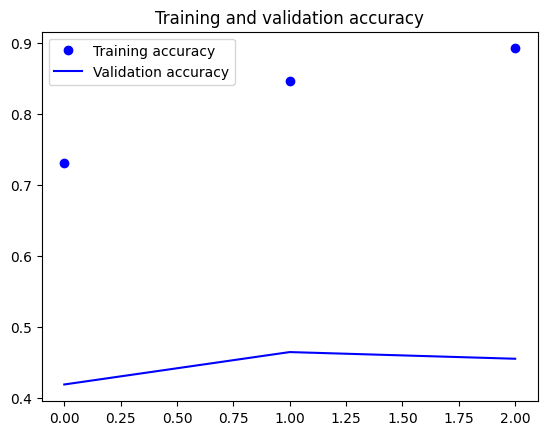

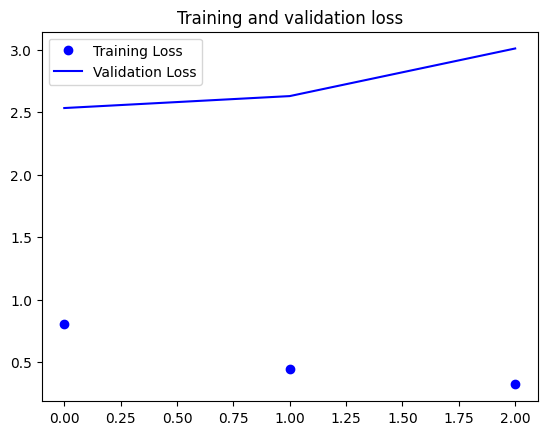

In [14]:
from tensorflow.keras.optimizers import RMSprop, AdamW

model.compile(loss='categorical_crossentropy',
          optimizer=AdamW(learning_rate=2e-4,  weight_decay=3e-4),
          metrics=['accuracy'])

# Constant for epochs
EPOCHS = 30
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, verbose=1)

# Train the model
history = model.fit(
      train_generator,
      epochs=EPOCHS,
      validation_data=validation_generator,
      callbacks=[early_stopping]
    )

model.save("checkpoint1")

# Plot training results
plot_loss_acc(history)

### Freezing ResNet and FineTuning Classifier Only
*With Weighted Class*

In [15]:
def getWeightedClass(data, power=1):
    total = data.shape[0]
    labels = data["Label"].unique()
    n_class= len(labels)

    class_weights = {}
    for label in labels:
        label_total = data[data['Label'] == label].shape[0]
        class_weights[label] = pow((1 / label_total) * (total / n_class),power)

    return class_weights

weights = getWeightedClass(data_info, 1/3)
weights

{0: 1.2002971372095308,
 1: 1.2228102442883089,
 8: 0.5978107620097575,
 7: 1.2417715581822708,
 6: 1.2190032139074416,
 4: 1.223577377641527,
 3: 1.239336705742807,
 5: 1.2446365653407978,
 2: 1.235719943818988}

Epoch 1/30


2024-02-11 05:07:04.504063: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


876/876 [==============================] - 43s 45ms/step - loss: 0.1630 - accuracy: 0.9411 - val_loss: 0.4260 - val_accuracy: 0.8692
Epoch 2/30
876/876 [==============================] - 38s 43ms/step - loss: 0.1204 - accuracy: 0.9588 - val_loss: 0.4030 - val_accuracy: 0.8769
Epoch 3/30
876/876 [==============================] - 37s 43ms/step - loss: 0.1079 - accuracy: 0.9642 - val_loss: 0.3912 - val_accuracy: 0.8815
Epoch 4/30
876/876 [==============================] - 37s 43ms/step - loss: 0.0981 - accuracy: 0.9675 - val_loss: 0.3831 - val_accuracy: 0.8835
Epoch 5/30
876/876 [==============================] - 38s 43ms/step - loss: 0.0929 - accuracy: 0.9684 - val_loss: 0.3774 - val_accuracy: 0.8838
Epoch 6/30
876/876 [==============================] - 37s 43ms/step - loss: 0.0875 - accuracy: 0.9714 - val_loss: 0.3730 - val_accuracy: 0.8883
Epoch 7/30
876/876 [==============================] - 38s 43ms/step - loss: 0.0825 - accuracy: 0.9726 - val_loss: 0.3702 - val_accuracy: 0.8912
Epo

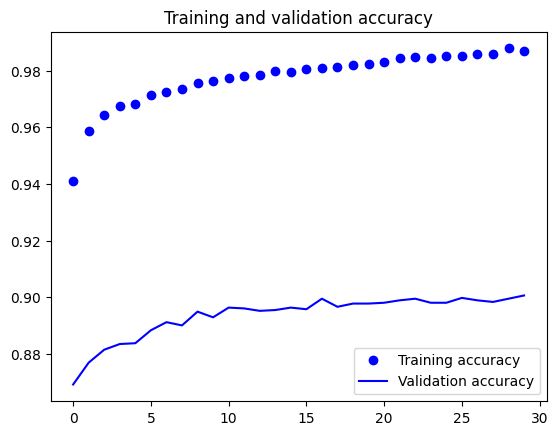

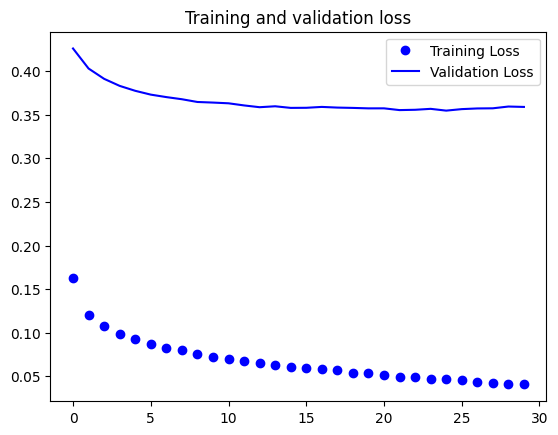

In [16]:
## Freezing ResNet50
model.layers[2].trainable = False
model.compile(loss='categorical_crossentropy',
          optimizer=AdamW(learning_rate=9e-6,  weight_decay=3e-5),
          metrics=['accuracy'])

# Constant for epochs
EPOCHS = 30
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# Train the model
history = model.fit(
      train_generator,
      epochs=EPOCHS,
      validation_data=validation_generator,
      callbacks=[early_stopping],
      class_weight=weights
    )

model.save("checkpoint2")

# Plot training results
plot_loss_acc(history)

### Evaluations

In [17]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay

rand_guess = 0

def prediction_argmax(prediction):
    l_pred = np.argmax(prediction[:8])
    if(prediction[l_pred] > rand_guess):
        return l_pred

    return np.argmax(prediction)

def eval_model(data, use_rand_guess=False):
    print("model.evaluate")
    model.evaluate(data)

    print("model.predict")
    data.reset()
    actual_labels = data.labels
    data.reset()

    if use_rand_guess:
        prediction = [prediction_argmax(x) for x in model.predict(data)]
    else:
        prediction = [np.argmax(x) for x in model.predict(data)]

    print("Statistics")
    print("F1-Score",f1_score(actual_labels,prediction,average='weighted'))
    print("Precision-Score",precision_score(actual_labels,prediction,average='weighted'))
    print("Recall-Score",recall_score(actual_labels,prediction,average='weighted'))
    print("accuracy_Score",accuracy_score(actual_labels,prediction))
    print()

    cmd = ConfusionMatrixDisplay(tf.math.confusion_matrix(actual_labels,prediction,num_classes=9).numpy())
    cmd.plot()
    plt.show()

In [18]:
## Computing Random guess

validation_generator.reset()
actual_labels = validation_generator.labels
validation_generator.reset()
pred = model.predict(validation_generator)

thresholds = []
for i in range(len(actual_labels)):
    n_label = prediction_argmax(pred[i])
    ap_label = np.argmax(pred[i])
    a_label = actual_labels[i]

    if(n_label == a_label):
        thresholds.append(pred[n_label])


rand_guess = np.mean(thresholds)
rand_guess

438/438 [==============================] - 9s 19ms/step


0.11111111

Evaluating Validation Set
---------Normal Eval--------------
model.evaluate
438/438 [==============================] - 9s 21ms/step - loss: 0.3589 - accuracy: 0.9006
model.predict
438/438 [==============================] - 8s 18ms/step
Statistics
F1-Score 0.900203900752944
Precision-Score 0.9000488726519902
Recall-Score 0.9006282124500286
accuracy_Score 0.9006282124500286



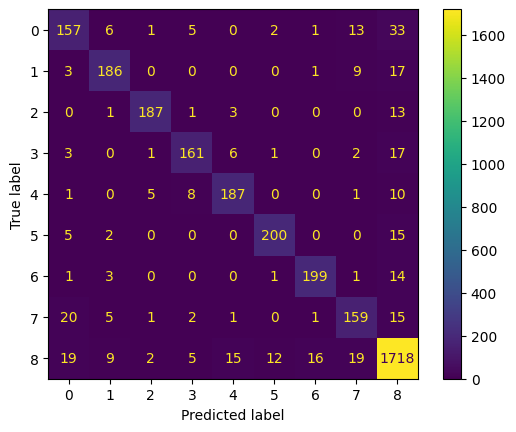

In [19]:
print("Evaluating Validation Set\n---------Normal Eval--------------")
eval_model(validation_generator)

In [20]:
prediction = [np.argmax(x) for x in pred]
per_class_accuracy = [0,0,0,0,0,0,0,0,0]
per_class_total = [0,0,0,0,0,0,0,0,0]
for i in range(len(actual_labels)):
    per_class_total[actual_labels[i]]+=1
    if actual_labels[i] == prediction[i]:
        per_class_accuracy[actual_labels[i]] += 1


print("Predictions",per_class_accuracy)
print("Actual",per_class_total)
np.array(per_class_accuracy) / np.array(per_class_total)

Predictions [157, 186, 187, 161, 187, 200, 199, 159, 1718]
Actual [218, 216, 205, 191, 212, 222, 219, 204, 1815]


array([0.72018349, 0.86111111, 0.91219512, 0.84293194, 0.88207547,
       0.9009009 , 0.9086758 , 0.77941176, 0.94655647])


Evaluating Validation Set
---------RandGuess Eval--------------
model.evaluate
438/438 [==============================] - 9s 21ms/step - loss: 0.3589 - accuracy: 0.9006
model.predict
438/438 [==============================] - 8s 18ms/step
Statistics
F1-Score 0.891035995175232
Precision-Score 0.8945770707840263
Recall-Score 0.8894917190177042
accuracy_Score 0.8894917190177042



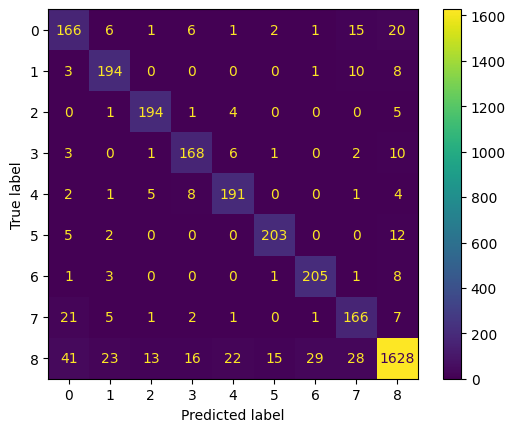

In [21]:
print("\nEvaluating Validation Set\n---------RandGuess Eval--------------")
eval_model(validation_generator, use_rand_guess=True)

In [22]:
prediction = [prediction_argmax(x) for x in pred]
per_class_accuracy = [0,0,0,0,0,0,0,0,0]
per_class_total = [0,0,0,0,0,0,0,0,0]
for i in range(len(actual_labels)):
    per_class_total[actual_labels[i]]+=1
    if actual_labels[i] == prediction[i]:
        per_class_accuracy[actual_labels[i]] += 1


print("Predictions",per_class_accuracy)
print("Actual",per_class_total)
np.array(per_class_accuracy) / np.array(per_class_total)

Predictions [166, 194, 194, 168, 191, 203, 205, 166, 1628]
Actual [218, 216, 205, 191, 212, 222, 219, 204, 1815]


array([0.76146789, 0.89814815, 0.94634146, 0.87958115, 0.9009434 ,
       0.91441441, 0.93607306, 0.81372549, 0.8969697 ])

In [ ]:
shutil.rmtree(base_dir)